In [1]:
import cv2
from glob import glob
import keras
from keras.applications.imagenet_utils import preprocess_input
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
from scipy.misc import imrotate
import tensorflow as tf

from ssd_with_rotation import GRWeightScheduler
from ssd_with_rotation import SSD300_DANN
from ssd_with_rotation import MultiboxLoss
from ssd_with_rotation import BBoxUtility
from ssd_with_rotation import MAPCallback

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
# some constants
NUM_CLASSES = 4
input_shape = (300, 300, 3)
# priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
priors = np.load('prior_boxes_rotated.npy')
bbox_util = BBoxUtility(NUM_CLASSES, priors)
gt = np.load('gt_pascal_new.npy')[()]
keys = sorted(gt.keys())

In [3]:
ious = []
for kn, key in enumerate(keys):
    if kn % 250 == 0:
        print(kn)
    q, w = bbox_util.assign_boxes(gt[key], return_iou=True)
    ious.extend(w)
ious = np.array(ious)

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000


In [13]:
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]

In [17]:
np.savetxt('tmp.txt', val_keys, fmt='%s')

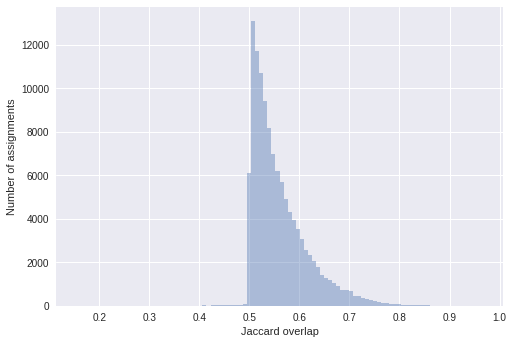

In [12]:
import seaborn as sns
ax = sns.distplot(ious, kde=False, bins=100)
ax.set(xlabel='Jaccard overlap', ylabel='Number of assignments')
plt.savefig('assignments.pdf')

In [1]:
import cv2
from glob import glob
import keras
from keras.applications.imagenet_utils import preprocess_input
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
# config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
from ssd_with_rotation import SSD300

In [3]:
# some constants
NUM_CLASSES = 4
input_shape = [300, 300, 3]

In [ ]:
model = SSD300(input_shape, NUM_CLASSES)

In [ ]:
model.load_weights('angle_10/w.29-3.45.h5', by_name=True)

In [ ]:
inputs = np.random.rand(1, 300, 300, 3)

In [ ]:
pred = model.predict(inputs)

In [ ]:
pred.shape

In [ ]:
np.save('prior_boxes_rotated', pred[0][:, -9:])

In [4]:
gt_pascal = np.load('gt_pascal_new.npy')[()]
priors = np.load('prior_boxes_rotated.npy')

In [ ]:
for key in gt_pascal:
    for i in range(len(gt_pascal[key])):
        gt_pascal[key][i][4] = (180 - gt_pascal[key][i][4]) / 180 * np.pi

In [ ]:
np.save('gt_pascal_new', gt_pascal)

In [ ]:
tmp_old = pickle.load(open('../../segmentation/points_per_obj.pkl', 'rb'))
# tmp_old = pickle.load(open('../../segmentation/points_dict_v2.pkl', 'rb'))

In [ ]:
tmp = {}
for obj_key in tmp_old.keys():
    if obj_key[:-4] == 'bottle':
        cls = 0
    elif obj_key[:-4] == 'white_bottle':
        cls = 1
    else:
        cls = 2
    for frame_key in tmp_old[obj_key].keys():
        test = np.array(tmp_old[obj_key][frame_key]).squeeze()
        try:
            tmp[frame_key].append((test, cls))
        except:
            tmp[frame_key] = [(test, cls)]

In [8]:
keys = sorted(gt_pascal.keys())
path_prefix = '../../frames/'
color = [0, 0, 0]

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
encoder.fit([0, 1, 2])

In [ ]:
gt_pascal = {}
for i, key in enumerate(keys):
    gt_pascal[key] = []
    for cross in tmp[key]:
        if len(cross[0]) > 0:
            label = encoder.transform([cross[1]]).squeeze()
            pt1 = np.array([cross[0][0][1] / 640,
                            cross[0][0][0] / 360])
            pt2 = np.array([cross[0][1][1] / 640,
                            cross[0][1][0] / 360])
            pt3 = np.array([cross[0][2][1] / 640,
                            cross[0][2][0] / 360])
            pt4 = np.array([cross[0][3][1] / 640,
                            cross[0][3][0] / 360])
            xc, yc = (pt1 + pt2) / 2
            vect_main = pt1 - pt2
            h = np.linalg.norm(vect_main)
            w = np.linalg.norm(pt3 - pt4)
            a = np.arccos(vect_main[0] * np.sign(vect_main[1]) / h)
            res = np.empty(5 + len(label))
            res[0] = xc
            res[1] = yc
            res[2] = h
            res[3] = w
            res[4] = a / np.pi * 180
            res[5:] = label
            gt_pascal[key].append(res)
    gt_pascal[key] = np.array(gt_pascal[key])
np.save('gt_pascal', gt_pascal)

In [145]:
ious = []
for kn, key in enumerate(keys):
    if kn % 250 == 0:
        print(kn)
    q, w = bbox_util.assign_boxes(gt_pascal[key], return_iou=True)
    ious.extend(w)
ious = np.array(ious)

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000


In [146]:
ious.mean(), ious.std(), ious.max(), ious.min()

(0.5598042815783314,
 0.056016858394874976,
 0.96572919443084659,
 0.15480534299214929)

In [147]:
(ious > 0.5).mean()

0.99502669122202514

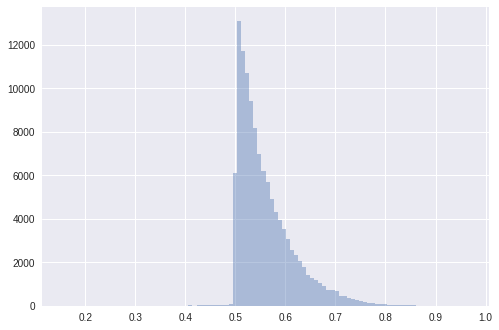

In [148]:
import seaborn as sns
sns.distplot(ious, kde=False, bins=100)

In [151]:
for kn, key in enumerate(keys):
    if kn % 250 == 0:
        print(kn)
    img = cv2.imread(path_prefix + key)
    img = cv2.resize(img, (640, 360))
    for box in gt_pascal[key]:
        img = bbox_util.draw_box_on_image(img, box)
    q, w = bbox_util.assign_boxes(gt_pascal[key], return_iou=True)
    priors_coords = np.where(q[:, -9] == 1)[0]
#     a = bbox_util.decode_boxes(q[:, :6], priors[:, :5], priors[:, 5:])
# #     for box in a[q[:, -9] == 1]:
# #         color = [255, 255, 0]
# #         img = bbox_util.draw_box_on_image(img, box, color)
    for pn, priors_coord in enumerate(priors_coords):
        box = priors[priors_coord]
        color = [255, 255, 0]
        img = bbox_util.draw_box_on_image(img, box, color,
                                          '{:.2f}'.format(w[pn]))
    cv2.putText(img, key, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.65, [255, 255, 255], 2)
    out.write(img)
out.release()

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000


In [150]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('test_annotation.avi', fourcc, 30.0, (640, 360))

In [ ]:
for i, key in enumerate(keys):
    if (i + 1) % 250 == 0:
        print(i + 1)
    img = cv2.imread(path_prefix + key)
    img = cv2.resize(img, (640, 360))
    for cross in tmp[key]:
        if len(cross[0]) > 0:
            color[cross[1]] = 255
            pt1 = (cross[0][0][1], cross[0][0][0])
            pt2 = (cross[0][1][1], cross[0][1][0])
            cv2.line(img, pt1, pt2, color, thickness=2)
            pt1 = (cross[0][2][1], cross[0][2][0])
            pt2 = (cross[0][3][1], cross[0][3][0])
            cv2.line(img, pt1, pt2, color, thickness=2)
            color[cross[1]] = 0
    cv2.putText(img, key, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.65, [255, 255, 255], 2)
    out.write(img)
out.release()

In [135]:
"""Some utils for SSD."""

import cv2
import numpy as np
import tensorflow as tf

import Polygon as plg
import Polygon.Shapes as shapes


class BBoxUtility(object):
    """Utility class to do some stuff with bounding boxes and priors.

    # Arguments
        num_classes: Number of classes including background.
        priors: Priors and variances, numpy tensor of shape (num_priors, 9),
            priors[i] = [xc, yc, w, h, alpha, varxc, varyc, varw, varh].
        overlap_threshold: Threshold to assign box to a prior.

    # References
        https://arxiv.org/abs/1512.02325
    """
    def __init__(self, num_classes, priors=None, overlap_threshold=0.5):
        self.num_classes = num_classes
        self.priors = priors
        self.rect_priors = []
        for prior in priors:
            rect = shapes.Rectangle(prior[2], prior[3])
            rect.shift(prior[0] - prior[2]/2, -prior[1] - prior[3]/2)
            rect.rotate(prior[4])
            self.rect_priors.append((rect, rect.area()))
        self.num_priors = 0 if priors is None else len(priors)
        self.overlap_threshold = overlap_threshold

    def rects_iou(self, box):
        """Compute intersection over union for the box with all priors.

        # Arguments
            box: Box, numpy tensor of shape (5,).

        # Return
            iou: Intersection over union,
                numpy tensor of shape (num_priors).
        """
        # compute intersection
        box_rect = shapes.Rectangle(box[2], box[3])
        box_rect.shift(box[0] - box[2]/2, -box[1] - box[3]/2)
        box_rect.rotate(box[4])
        box_area = box_rect.area()
        iou = np.zeros(self.num_priors)
        for i, prior_rect in enumerate(self.rect_priors):
            inter_area = (box_rect & prior_rect[0]).area()
            union_area = box_area + prior_rect[1] - inter_area
            iou[i] = inter_area / union_area
        return iou

    def encode_box(self, box, return_iou=True):
        """Encode box for training, do it only for assigned priors.

        # Arguments
            box: Box, numpy tensor of shape (5,).
            return_iou: Whether to concat iou to encoded values.

        # Return
            encoded_box: Tensor with encoded box
                numpy tensor of shape (num_priors, 6 + int(return_iou)).
        """
        iou = self.rects_iou(box)
        encoded_box = np.zeros((self.num_priors, 6 + return_iou))
        assign_mask = iou > self.overlap_threshold
        if not assign_mask.any():
            assign_mask[iou.argmax()] = True
        if return_iou:
            encoded_box[:, -1][assign_mask] = iou[assign_mask]
        assigned_priors = self.priors[assign_mask]
        box_center = box[:2]
        box_wh = box[2:4]
        assigned_priors_center = assigned_priors[:, :2]
        assigned_priors_wh = assigned_priors[:, 2:4]
        # we encode variance
        encoded_box[:, :2][assign_mask] = box_center - assigned_priors_center
        encoded_box[:, :2][assign_mask] /= assigned_priors_wh
        encoded_box[:, :2][assign_mask] /= assigned_priors[:, -4:-2]
        encoded_box[:, 2:4][assign_mask] = np.log(box_wh /
                                                  assigned_priors_wh)
        encoded_box[:, 2:4][assign_mask] /= assigned_priors[:, -2:]
        # compute angle encodings
        # relative angle
        angle_change = (box[4] - assigned_priors[:, 4])
        # absolute angle
#         angle_change = box[4]
        encoded_box[:, 4][assign_mask] = np.cos(2 * angle_change)
        encoded_box[:, 5][assign_mask] = np.sin(2 * angle_change)
        return encoded_box.ravel()

    def assign_boxes(self, boxes, return_iou=False):
        """Assign boxes to priors for training.

        # Arguments
            boxes: Box, numpy tensor of shape (num_boxes, 5 + num_classes),
                num_classes without background.

        # Return
            assignment: Tensor with assigned boxes,
                numpy tensor of shape (num_boxes, 6 + num_classes + 9),
                priors in ground truth are fictitious,
                assignment[:, -9] has 1 if prior should be penalized
                    or in other words is assigned to some ground truth box,
                assignment[:, -8:] are all 0. See loss for more details.
        """
        assignment = np.zeros((self.num_priors, 6 + self.num_classes + 9))
        assignment[:, 6] = 1.0
        if len(boxes) == 0:
            return assignment
        encoded_boxes = np.apply_along_axis(self.encode_box, 1, boxes[:, :5])
        encoded_boxes = encoded_boxes.reshape(-1, self.num_priors, 7)
        best_iou = encoded_boxes[:, :, -1].max(axis=0)
        best_iou_idx = encoded_boxes[:, :, -1].argmax(axis=0)
        best_iou_mask = best_iou > 0
        best_iou_idx = best_iou_idx[best_iou_mask]
        assign_num = len(best_iou_idx)
        encoded_boxes = encoded_boxes[:, best_iou_mask, :]
        assignment[:, :6][best_iou_mask] = encoded_boxes[best_iou_idx,
                                                         np.arange(assign_num),
                                                         :-1]
        assignment[:, 6][best_iou_mask] = 0
        assignment[:, 7:-9][best_iou_mask] = boxes[best_iou_idx, 5:]
        assignment[:, -9][best_iou_mask] = 1
        if return_iou:
            return assignment, best_iou[best_iou_mask]
        return assignment
    
    def decode_boxes(self, mbox_loc, mbox_priorbox, variances):
        """Convert bboxes from local predictions to shifted priors.

        # Arguments
            mbox_loc: Numpy array of predicted locations.
            mbox_priorbox: Numpy array of prior boxes.
            variances: Numpy array of variances.

        # Return
            decode_bbox: Shifted priors.
        """
        prior_width = mbox_priorbox[:, 2]
        prior_height = mbox_priorbox[:, 3]
        prior_center_x = mbox_priorbox[:, 0]
        prior_center_y = mbox_priorbox[:, 1]
        prior_angle = mbox_priorbox[:, 4]
        # decode coordinates
        decode_bbox_center_x = mbox_loc[:, 0] * prior_width * variances[:, 0]
        decode_bbox_center_x += prior_center_x
        decode_bbox_center_y = mbox_loc[:, 1] * prior_height * variances[:, 1]
        decode_bbox_center_y += prior_center_y
        decode_bbox_width = np.exp(mbox_loc[:, 2] * variances[:, 2])
        decode_bbox_width *= prior_width
        decode_bbox_height = np.exp(mbox_loc[:, 3] * variances[:, 3])
        decode_bbox_height *= prior_height
        # decode angle
        decode_bbox_angle = (np.arccos(mbox_loc[:, 4]) / 2)
        decode_bbox_angle[mbox_loc[:, 5] < 0] -= np.pi
        decode_bbox_angle[mbox_loc[:, 5] < 0] *= -1
        # relative_angle
        decode_bbox_angle += prior_angle
        decode_bbox = np.concatenate((decode_bbox_center_x[:, None],
                                      decode_bbox_center_y[:, None],
                                      decode_bbox_width[:, None],
                                      decode_bbox_height[:, None],
                                      decode_bbox_angle[:, None]), axis=-1)
        return decode_bbox

    def detection_out(self, predictions, background_label_id=0, keep_top_k=200,
                      nms_thresh=0.4, confidence_threshold=0.5):
        """Do non maximum suppression (nms) on prediction results.

        # Arguments
            predictions: Numpy array of predicted values.
            num_classes: Number of classes for prediction.
            background_label_id: Label of background class.
            keep_top_k: Number of total bboxes to be kept per image
                after nms step.
            nms_thresh: Nms threshold.
            confidence_threshold: Only consider detections,
                whose confidences are larger than a threshold.

        # Return
            results: List of predictions for every picture. Each prediction is:
                [label, confidence, xmin, ymin, xmax, ymax]
        """
        mbox_loc = predictions[:, :, :6]
        variances = predictions[:, :, -4:]
        mbox_priorbox = predictions[:, :, -9:-4]
        mbox_conf = predictions[:, :, 6:-9]
        results = []
        for i in range(len(mbox_loc)):
            results.append([])
            decode_bbox = self.decode_boxes(mbox_loc[i],
                                            mbox_priorbox[i], variances[i])
            for c in range(self.num_classes):
                if c == background_label_id:
                    continue
                c_confs = mbox_conf[i, :, c]
                c_confs_m = c_confs > confidence_threshold
                if len(c_confs[c_confs_m]) > 0:
                    boxes_to_process = decode_bbox[c_confs_m]
                    confs_to_process = c_confs[c_confs_m]
                    idx = self.do_nms(boxes_to_process,
                                      confs_to_process, nms_thresh)
                    good_boxes = boxes_to_process[idx]
                    confs = mbox_conf[i, :, :][c_confs_m][idx]
                    c_pred = np.concatenate((good_boxes, confs), axis=1)
                    results[-1].extend(c_pred)
            if len(results[-1]) > 0:
                results[-1] = np.array(results[-1])
                if len(results[-1]) > keep_top_k:
                    argsort = np.argsort(results[-1][:, 5:].max(axis=1))
                    argsort = argsort[::-1]
                    results[-1] = results[-1][argsort]
                    results[-1] = results[-1][:keep_top_k]
            else:
                results[-1] = np.array(results[-1])
                results[-1] = results[-1].reshape(-1, 4 + self.num_classes)
        return results
    
    def rotated_iou(self, box1, box2):
        rect1 = shapes.Rectangle(box1[2], box1[3])
        rect1.shift(box1[0] - box1[2]/2, -box1[1] - box1[3]/2)
        rect1.rotate(box1[4])
        rect2 = shapes.Rectangle(box2[2], box2[3])
        rect2.shift(box2[0] - box2[2]/2, -box2[1] - box2[3]/2)
        rect2.rotate(box2[4])
        return (rect1 & rect2).area() / (rect1 | rect2).area()
    
    def do_nms(self, boxes, confs, nms_thresh):
        """Greedily select boxes.
        
        # Arguments
            boxes: Boxes coords, tensor of shape (num_boxes, 5)
            confs: Confidenses, tensor of shape (num_boxes)
            nms_thresh: Nms threshold.
            
        # Returns
            idx: Indexes of selected boxes, tensor of shape (num_selected)
        """
        idx = []
        c_sorted_idx = np.argsort(confs)[::-1]
        for c_idx in c_sorted_idx:
            box = boxes[c_idx]
            should_take = True
            for saved_i in idx:
                iou = self.rotated_iou(box, boxes[saved_i])
                if iou >= nms_thresh:
                    should_take = False
                    break
            if should_take:
                idx.append(c_idx)
        return np.array(idx)        
    
    def draw_box_on_image(self, img, box, color=None, text=None):
        """Draw rotated box on image.

        # Arguments
            img: Image to draw on.
            box: Box to draw, numpy tensor of shape(5,) or (8,)
            color: Optional color of the box.
            text: Optional text to put in the box.

        # Return
            img: Image with box.
        """
        img_h, img_w, _ = img.shape
        x_main = box[2] * np.cos(box[4]) * img_w
        y_main = box[2] * np.sin(box[4]) * img_h
        h_new = np.linalg.norm([x_main, y_main])
        dir_mult = np.sign(y_main) if y_main != 0 else 1
        angle_new = np.arccos(x_main * dir_mult / h_new) / np.pi * 180
        x_main = box[3] * np.cos(box[4] + 0.5*np.pi) * img_w
        y_main = box[3] * np.sin(box[4] + 0.5*np.pi) * img_h
        w_new = np.linalg.norm([x_main, y_main])
        rect = ((box[0] * img_w, box[1] * img_h),
                (h_new, w_new),
                -angle_new)
        rect_p = cv2.boxPoints(rect)
        if color is None:
            color = box[5:] * 255
        for i in range(4):
            cv2.line(img, tuple(rect_p[i]),
                     tuple(rect_p[(i + 1) % 4]), color, thickness=2)
        if text:
            cv2.putText(img, text,
                        (int(rect[0][0]), int(rect[0][1])),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.3, [255, 255, 255], 1)
        return img

In [136]:
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [137]:
qwe, w = bbox_util.assign_boxes(gt_pascal['frame00550.png'], return_iou=True)

In [138]:
w

array([ 0.52849176,  0.52698271,  0.5268243 ,  0.52848095,  0.53140096,
        0.52750088,  0.51438406,  0.51335271,  0.52362912,  0.52728395,
        0.5034063 ,  0.55071227,  0.60215684,  0.63718327,  0.63441679,
        0.57772063,  0.50686718,  0.57291004,  0.63895463,  0.62286388,
        0.55387866,  0.55400712,  0.55791869,  0.55805698,  0.55507827,
        0.55034541,  0.55040812,  0.55636006,  0.55146896,  0.5473408 ,
        0.56766737,  0.51593029,  0.55190209,  0.60401737,  0.62642827,
        0.62489904,  0.63883903,  0.61965191,  0.50098889,  0.52898207,
        0.54850615,  0.56863174,  0.55279206,  0.46393923])

In [139]:
priors_coords = np.where(qwe[:, -9] == 1)[0]

In [140]:
priors[priors_coords[-1]], gt_pascal['frame00550.png'][1]

(array([ 0.40000001,  0.45333335,  0.25980762,  0.08660254,  1.39626336,
         0.1       ,  0.1       ,  0.2       ,  0.2       ], dtype=float32),
 array([ 0.40390625,  0.43333333,  0.40623223,  0.05377462,  1.51306944,
         1.        ,  0.        ,  0.        ]))

In [141]:
bbox_util.rotated_iou(priors[priors_coords[-1]], gt_pascal['frame00550.png'][1])

0.46393922951283656

In [ ]:
train_res = pickle.load(open('angle10_trainres.pkl', 'rb'))
train_keys = sorted(train_res.keys())

In [ ]:
val_res = pickle.load(open('angle10_valres.pkl', 'rb'))
val_keys = sorted(val_res.keys())

In [126]:
from Polygon.IO import writeSVG
from Polygon.Utils import pointList

In [134]:
rect1 = shapes.Rectangle(priors[priors_coords[-1]][2], priors[priors_coords[-1]][3])
rect1.shift(priors[priors_coords[-1]][0] - priors[priors_coords[-1]][2]/2,
            -priors[priors_coords[-1]][1] - priors[priors_coords[-1]][3]/2)
rect1.rotate(priors[priors_coords[-1]][4])
rect2 = shapes.Rectangle(gt_pascal['frame00550.png'][1][2], gt_pascal['frame00550.png'][1][3])
rect2.shift(gt_pascal['frame00550.png'][1][0] - gt_pascal['frame00550.png'][1][2]/2,
            -gt_pascal['frame00550.png'][1][1] - gt_pascal['frame00550.png'][1][3]/2)
rect2.rotate(gt_pascal['frame00550.png'][1][4])
rect3 = shapes.Rectangle(0.01, 0.01)
rect3.shift(priors[priors_coords[-1]][0] - 0.01/2, -priors[priors_coords[-1]][1] - 0.01/2)
rect3.rotate(priors[priors_coords[-1]][4])
writeSVG('test.svg', [rect1, rect2, rect3])

<_io.TextIOWrapper name='test.svg' mode='w' encoding='ANSI_X3.4-1968'>

In [142]:
key = 'frame00550.png'
img = cv2.imread(path_prefix + key)
img = cv2.resize(img, (640, 360))

In [143]:
img = bbox_util.draw_box_on_image(img, gt_pascal['frame00550.png'][1], color=[255, 0, 0])
img = bbox_util.draw_box_on_image(img, priors[priors_coords[-1]], color=[255, 255, 0])

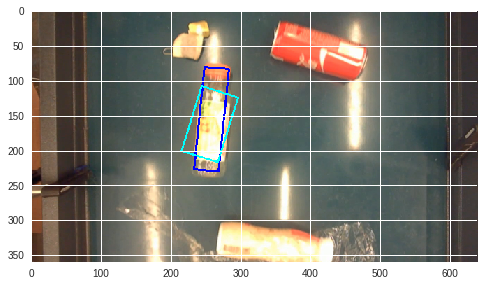

In [144]:
plt.imshow(img[:, :, ::-1])

In [ ]:
tmp = bbox_util.detection_out(train_res[train_keys[0]][None, :])

In [ ]:
key = train_keys[0]
img = cv2.imread(path_prefix + key)
img = cv2.resize(img, (640, 360))

In [ ]:
import Polygon as plg
import Polygon.Shapes as shapes

In [ ]:
for box1 in tmp[0][:1]:
    rect = shapes.Rectangle(box1[2], box1[3])
    rect.shift(box1[0], -box1[1])
    rect.rotate(-box1[4] / 180 * np.pi)
#     print(rect.area())
    for box2 in tmp[0]:
        rect2 = shapes.Rectangle(box2[2], box2[3])
        rect2.shift(box2[0], -box2[1])
        rect2.rotate(-box2[4] / 180 * np.pi)
#         print(rect2.area())
#         print((rect & rect2).area(), (rect | rect2).area(),
#               (rect & rect2).area() / (rect | rect2).area())
#         print(box2[2] * box[3])
        q, w, e, r, t, y = bbox_util.rotated_iou(box1, box2)
        qwe = cv2.approxPolyDP(y, 1e-4, True)
        print(cv2.contourArea(y), cv2.contourArea(qwe), cv2.isContourConvex(y))

In [ ]:
for box in tmp[0]:
    color = [0, 0, 0]
    color[box[-3:].argmax()] = 255
    img = bbox_util.draw_box_on_image(img, box[:5], color)

In [ ]:
plt.imshow(img[:, :, ::-1])

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('angle10_trainres.avi', fourcc, 30.0, (640, 360))
# out = cv2.VideoWriter('angle10_valres.avi', fourcc, 30.0, (640, 360))

In [ ]:
for i, key in enumerate(train_keys):
# for i, key in enumerate(val_keys):
    if i % 250 == 0:
        print(i)
    img = cv2.imread(path_prefix + key)
    img = cv2.resize(img, (640, 360))
    res = train_res[key][None, :]
#     res = val_res[key][None, :]
    boxes = bbox_util.detection_out(res)[0]
    probs_idx = boxes[:, -3:].argmax(axis=-1)
    for i, box in enumerate(boxes):
        prob_idx = probs_idx[i]
        color = [0, 0, 0]
        color[prob_idx] = 255
        img = bbox_util.draw_box_on_image(img, box[:5], color)
    out.write(img)
out.release()